###  MicroGrad demo

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from mycrograd_debug.engine_debug import Value
from mycrograd_debug.nn_debug import Neuron, Layer, MLP

In [11]:
np.random.seed(1337)
random.seed(1337)
number_of_samples=10
number_of_iterations=30

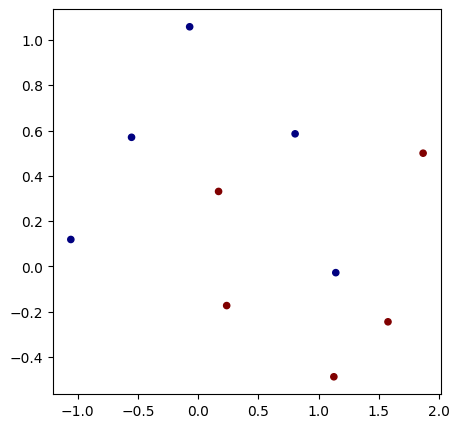

In [12]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=number_of_samples, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [13]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

Module nn MLP: structure [2, 16, 16, 1]
MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [14]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(name=v279206,layernumber=,neuronnumber=,weightnumber=,type=,data=0.9177316280600332, grad=0) 0.5


In [15]:


# optimization
for k in range(number_of_iterations):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.9177316280600332, accuracy 50.0%
step 1 loss 1.927341623405934, accuracy 80.0%
step 2 loss 0.5716475206128804, accuracy 60.0%
step 3 loss 0.47109153388089264, accuracy 80.0%
step 4 loss 0.4586172786246078, accuracy 80.0%
step 5 loss 0.4891847627095518, accuracy 80.0%
step 6 loss 0.41079761293663325, accuracy 80.0%
step 7 loss 0.587102484190092, accuracy 80.0%
step 8 loss 0.5425594986400958, accuracy 80.0%
step 9 loss 0.5644615637013252, accuracy 80.0%
step 10 loss 0.5169185394218486, accuracy 80.0%
step 11 loss 0.3827915307739452, accuracy 80.0%
step 12 loss 0.38310399987818705, accuracy 80.0%
step 13 loss 0.30378427673478503, accuracy 90.0%
step 14 loss 0.2990053863480113, accuracy 90.0%
step 15 loss 0.3493513319223736, accuracy 90.0%
step 16 loss 0.5135603582347649, accuracy 80.0%
step 17 loss 0.29471638180615223, accuracy 90.0%
step 18 loss 0.2747332521088749, accuracy 90.0%
step 19 loss 0.2698031547438737, accuracy 90.0%
step 20 loss 0.4389736072090078, accuracy 80.0%

(-1.48793322559311, 2.01206677440689)

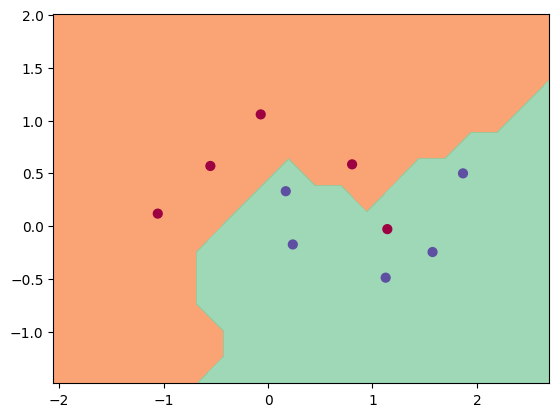

In [16]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
